In [1]:
## import section

import numpy as np
import networkx as nx
import dimod
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
from collections import defaultdict
import itertools
import pandas as pd


from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.system import LeapHybridSampler

In [2]:
# 0.0  79.68  79.72 0.56  53.53
# 0.013  0.0  1.0  142.97  0.67
# 0.013  1.0  0.0  143.08  0.68
# 1.79 6.007  0.107  0.0  97.37
# 0.019  1.48  1.49  0.010 0.0



# 1  1.13217  1.11777 120.756
# 0.8818 1 0.98804 106.034
# 0.892817  1.0075566 1 105.564
# 0.00827218 0.009410 0.0092365 1


In [3]:
from math import log
from typing import Tuple, List

def negate_logarithm_convertor(graph: Tuple[Tuple[float]]) -> List[List[float]]:
    ''' log of each rate in graph and negate it'''
    result = [[-log(edge) for edge in row] for row in graph]
    return result

In [4]:
# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

# load dataset
# data = pd.read_csv('five_d.txt', sep='\s+', header=None)
rates = [
    [1, 0.23, 0.25, 16.43, 18.21, 4.94],
    [4.34, 1, 1.11, 71.40, 79.09, 21.44],
    [3.93, 0.90, 1, 64.52, 71.48, 19.37],
    [0.061, 0.014, 0.015, 1, 1.11, 0.30],
    [0.055, 0.013, 0.014, 0.90, 1, 0.27],
    [0.20, 0.047, 0.052, 3.33, 3.69, 1],
]
#these are the values of differences in the currencies
# we can stream realtime values (contineously load) of currencies and place those in a matrix.
# currency_vals = data.values
## we can even put a window of 1 horus to reload the values and run all code again if values got updated.

In [5]:
data = pd.DataFrame(rates)

In [6]:
# distance between two example cities
idx_homecurrency = 2
idx_currency2 = 1
profit = data[idx_homecurrency][idx_currency2]
print('differnece between currency {} and currency {} is {}.'.format(idx_homecurrency, idx_currency2, profit))

# get number of cities
num_currencies = data.shape[0]
print('Total number of currencies:', num_currencies)

differnece between currency 2 and currency 1 is 1.11.
Total number of currencies: 6


In [7]:

currency_values = data.values


In [8]:
currency_data = negate_logarithm_convertor(currency_values)
currency_data

[[-0.0,
  1.4696759700589417,
  1.3862943611198906,
  -2.799108932049177,
  -2.9019708937395166,
  -1.5973653311998313],
 [-1.4678743481123135,
  -0.0,
  -0.10436001532424286,
  -4.268297869345539,
  -4.370586444531326,
  -3.0652583362026014],
 [-1.3686394258811698,
  0.10536051565782628,
  -0.0,
  -4.166975253257008,
  -4.2694176902912275,
  -2.9637254774189046],
 [2.796881414808826,
  4.268697949366879,
  4.199705077879927,
  -0.0,
  -0.10436001532424286,
  1.2039728043259361],
 [2.900422093749666,
  4.3428059215206005,
  4.268697949366879,
  0.10536051565782628,
  -0.0,
  1.3093333199837622],
 [1.6094379124341003,
  3.0576076772720784,
  2.9565115604007097,
  -1.2029723039923526,
  -1.3056264580524357,
  -0.0]]

In [9]:
currency_df = pd.DataFrame(currency_data)
currency_df

,0,1,2,3,4,5
0,-0.000000,1.469676,1.386294,-2.799109,-2.901971,-1.597365
1,-1.467874,-0.000000,-0.104360,-4.268298,-4.370586,-3.065258
2,-1.368639,0.105361,-0.000000,-4.166975,-4.269418,-2.963725
3,2.796881,4.268698,4.199705,-0.000000,-0.104360,1.203973
4,2.900422,4.342806,4.268698,0.105361,-0.000000,1.309333
5,1.609438,3.057608,2.956512,-1.202972,-1.305626,-0.000000


## Initial Graph for problem

Weights of graph: {(0, 0): 1.0, (0, 1): 4.34, (0, 2): 3.93, (0, 3): 0.061, (0, 4): 0.055, (0, 5): 0.2, (1, 1): 1.0, (1, 2): 0.9, (1, 3): 0.014, (1, 4): 0.013, (1, 5): 0.047, (2, 2): 1.0, (2, 3): 0.015, (2, 4): 0.014, (2, 5): 0.052, (3, 3): 1.0, (3, 4): 0.9, (3, 5): 3.33, (4, 4): 1.0, (4, 5): 3.69, (5, 5): 1.0}


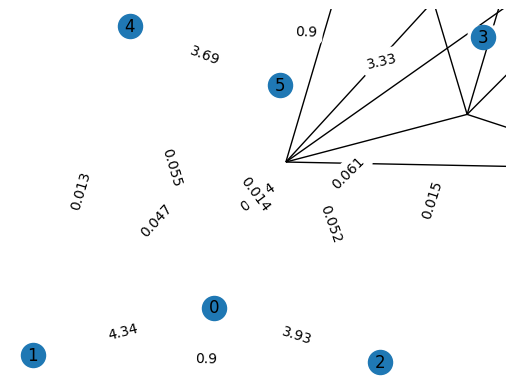

In [10]:
# G = nx.from_pandas_dataframe(data) 
G = nx.from_pandas_adjacency(data)
# pos = nx.random_layout(G) 
pos = nx.spring_layout(G, seed=seed)

# get characteristics of graph
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight');

# print weights of graph
print('Weights of graph:', weights)

# show graph with weights
plt.axis('off'); 
nx.draw_networkx(G, pos, with_labels=True);
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights);
plt.savefig("problem_stmt.png")

## problem formulation

In [11]:
# get QUBO for TSP
## define objective for tsp in qubo format
tsp_qubo = dnx.algorithms.tsp.traveling_salesperson_qubo(G)

In [12]:
def get_profit(path, data):
    """
    find distance for given path = [0, 4, 3, 1, 2] and original data
    """
    # get the total distance without return
    total_profit = 0
    base_price = 1
    for idx, node in enumerate(path[:-1]):
        dist = data[path[idx + 1]][path[idx]]
        total_profit += dist

    print("Total profit (without cycle):", total_profit)

    # add distance between start and end point to complete cycle
    return_profit= data[path[0]][path[-1]]
    # print('Distance between start and end:', return_distance)

    # get distance for full cycle
    profit_with_cycle = total_profit + return_profit
    print("Total profit (including cycle):", profit_with_cycle)

    return total_profit, profit_with_cycle

In [13]:
# find default Langrange parameter for enforcing constraints

# set parameters
lagrange = None
weight='weight'

# get corresponding QUBO step by step
N = G.number_of_nodes()

if lagrange is None:
    # If no lagrange parameter provided, set to 'average' tour length.
    # Usually a good estimate for a lagrange parameter is between 75-150%
    # of the objective function value, so we come up with an estimate for 
    # tour length and use that.
    if G.number_of_edges()>0:
        lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
    else:
        lagrange = 2

print('Default Lagrange parameter:', lagrange)   

# create list around default value for HPO 
lagrange_list= list(np.arange(int(0.8*lagrange), int(1.1*lagrange)))
# print('Lagrange parameter for HPO:', lagrange_list)

Default Lagrange parameter: 6.731714285714285


In [14]:
# lagrange = 5
lagrange_list = [6.731714285714285]

## solution with simulated annealing

In [15]:
# use (classical) simulated annealing
sampler = dimod.SimulatedAnnealingSampler()
path = dnx.traveling_salesperson(G, sampler, start=0)
print('path found with simulated annealing:', path)

# # get the total distance
# total_profit= 0
# for idx, node in enumerate(path[:-1]):
#     prof = data[path[idx+1]][path[idx]]
#     total_profit += prof

# print('Total profit (without cycle):', total_profit)

# # add distance between start and end point to complete cycle
# return_profit = data[path[0]][path[-1]]
# print('profit between start and end:', return_profit)

# # get distance for full cyle 
# profit = total_profit + return_profit
# print('Total profit (including cycle):', profit)

path found with simulated annealing: [0, 2, 3, 5, 4, 1]


In [16]:
# [0, 3, 1, 2, 0]
[0, 2, 3, 5, 4, 1]

[0, 2, 3, 5, 4, 1]

In [17]:
path.append(0)

In [18]:
# path = path.append(0)
path

[0, 2, 3, 5, 4, 1, 0]

In [19]:
# print(best
# _path)

In [20]:
def total_cost(mat,path):
    cost=1
    for i in range(len(path)-1):
        cost=cost*(mat[path[i]][path[i+1]])
    return cost
# mat=[[1,1.13217,1.11797,120.756],[0.8818,1,0.9880,106.034],[0.89281,1.00755,1,105.564],[0.008272,0.00941,0.009236,1]]
l= path
print(l)
total_cost(data.values,l)

[0, 2, 3, 5, 4, 1, 0]


1.0074304421999998

In [21]:
1.0023867565922493*1000

1002.3867565922493

## Dwave sampler

In [22]:
# run TSP with imported TSP routine
sampler = DWaveSampler()
sampler = EmbeddingComposite(sampler)

# set parameters
num_shots = 1000
start_curr = 0
best_profit = sum(weights.values())
best_path = [None]*len(G)

# run HPO to find route
for lagrange in lagrange_list:
    print('Running quantum annealing for TSP with Lagrange parameter=', lagrange)
    path = dnx.traveling_salesperson(G, sampler, lagrange=lagrange, 
                                  start=start_curr, num_reads=num_shots, answer_mode="histogram")
    # print route 
    print('path found with D-Wave:', path)
    
    # print distance
    total_profit, round_profit = get_profit(path, data)
    
    # update best values
    if round_profit > best_profit:
        best_profit = round_profit
        best_path = path

print('---FINAL SOLUTION---') 
print('Best solution found with D-Wave:', best_path)
print('Total [profit] (including cycle):', best_profit)

Running quantum annealing for TSP with Lagrange parameter= 6.731714285714285
path found with D-Wave: [0, 2, 3, 5, 4, 1]
Total profit (without cycle): 68.773
Total profit (including cycle): 73.113
---FINAL SOLUTION---
Best solution found with D-Wave: [0, 2, 3, 5, 4, 1]
Total [profit] (including cycle): 73.113


In [23]:
print('Total profit (including cycle):', best_profit)

Total profit (including cycle): 73.113


In [24]:
best_path.append(0)
print(best_path)

[0, 2, 3, 5, 4, 1, 0]


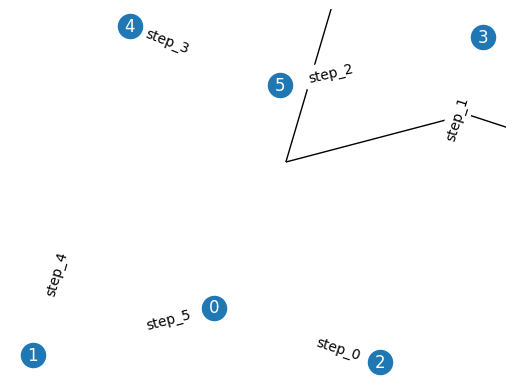

In [25]:
# get mapping from original nodes to position in cycle
node_labels = {list(nodes)[ii]: best_path[ii] for ii in range(num_currencies)}

# Construct route as list of (node_i, node_i+1)
sol_graph_base = [(best_path[idx], best_path[idx+1]) for idx in range(len(best_path)-1)]
# Establish weights between nodes along route, allowing for mirrored keys (i.e. weights[(0, 1)] = weights[(1, 0)])
best_weights = {k: weights[k] if k in weights.keys() else weights[(k[1],k[0])] for k in sol_graph_base}
# Rebuild graph containing only route connections
G_best = nx.Graph(sol_graph_base)

route_labels =  {x: f'step_{i}' for i, x in enumerate(sol_graph_base)} 
#{x: f'step_{i}={best_weights[x]}' for i, x in enumerate(sol_graph_base)}

# show solution
plt.axis('off'); 
nx.draw_networkx(G_best, pos, font_color='w');
nx.draw_networkx_edge_labels(G_best, pos, edge_labels=route_labels, label_pos=0.25);
plt.savefig("final_solution.png")

## conclusion

### in this way, we have completed our job to maxmizing the profit.